# Using CFKG to analyse the evolution of GHG Emission Conversion Factors through the years

## Required libraries

- `rdflib`
- `sparqlwrapper`
- `matplotlib`

## SPARQL endpoint

First let's setup the endpoint

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON

sparql = SPARQLWrapper(
    "https://sparql.cf.linkeddata.es/cf"
)
# if the SPARQL endpoint is down, you still have all the sources in our GitHub repository:
# https://github.com/TEC-Toolkit/cfkg
sparql.setReturnFormat(JSON)

## Queries

Now we need to choose the conversion factor.
This can be through a URI, or by determining emission source and emission target.
For example a CF that involves Compressed Natural Gas (CNG) and its transformation to CO2e.
We also have to determine the Scope of the emission (e.g., Scope 1).

Since there are too many, we add a restriction for the scope and so that the entity produced is measured in Kg.

In [2]:
sparql.setQuery("""
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX ecfo: <https://w3id.org/ecfo#>
    PREFIX qudt: <http://qudt.org/schema/qudt/>
    
    SELECT ?cf ?s ?t
    WHERE {
        ?cf ecfo:hasTag ?tag;
            ecfo:hasEmissionSource ?s;
            ecfo:hasEmissionTarget ?t;
            ecfo:hasTargetUnit ?tu;
            ecfo:hasScope ecfo:Scope1.
        ?tag rdfs:label "CNG"@en.
        ?t rdfs:label "carbon dioxide equivalent"@en.
        ?tu qudt:abbreviation "kg"@en.
        OPTIONAL {
            ?cf ecfo:hasAdditionalContext ?context
        }
    }
    """
)

ret = sparql.queryAndConvert()
for r in ret["results"]["bindings"]:
    print(r)

{'cf': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/UK/BEIS/2022/CF_17'}, 's': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/Gaseous_fuels_CNG'}, 't': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q1933140'}}
{'cf': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/UK/BEIS/2022/CF_21'}, 's': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/Gaseous_fuels_CNG'}, 't': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q1933140'}}
{'cf': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/UK/BEIS/2022/CF_25'}, 's': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/Gaseous_fuels_CNG'}, 't': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q1933140'}}
{'cf': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/UK/BEIS/2022/CF_29'}, 's': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/Gaseous_fuels_CNG'}, 't': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q1933140'}}
{'cf': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/UK/BEIS/2021/CF_17

We see that we get elements within two main contexts: Gross Calorific Value and Net Calorific Value.

Now let's get the data for different years only for those with a context.

In [3]:
from datetime import datetime

sparql.setQuery("""
    PREFIX rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX ecfo: <https://w3id.org/ecfo#>
    PREFIX qudt: <http://qudt.org/schema/qudt/>
    PREFIX time: <http://www.w3.org/2006/time#>

    SELECT ?cf ?value ?start ?end ?context
    WHERE {
        ?cf ecfo:hasTag ?tag;
            ecfo:hasEmissionTarget ?t;
            ecfo:hasTargetUnit ?tu;
            ecfo:hasAdditionalContext ?context;
            rdf:value ?value;
            ecfo:hasScope ecfo:Scope1;
            ecfo:hasApplicablePeriod ?period.
        ?tag rdfs:label "CNG"@en.
        ?t rdfs:label "carbon dioxide equivalent"@en.
        ?tu qudt:abbreviation "kg"@en.
        ?period time:hasBeginning/time:inXSDDate ?start;
                time:hasEnd/time:inXSDDate ?end.
    }
    """
)
## we force the context in this case

gross_values, net_values, gross_years, net_years = [],[],[],[]

ret = sparql.queryAndConvert()

for r in ret["results"]["bindings"]:
    # print(r)
    if "Gross CV" in r['context']['value']:
        gross_values.append(float(r['value']['value']))
        gross_years.append(datetime.strptime(r['start']['value'], '%Y-%m-%dT%H:%M:%S').year)
    elif "Net CV" in r['context']['value']:
        net_values.append(float(r['value']['value']))
        net_years.append(datetime.strptime(r['start']['value'], '%Y-%m-%dT%H:%M:%S').year)


print("Gross values:", gross_values)
print("Gross years:", gross_years)
print("Net values:", net_values)
print("Net years:", net_years)

Gross values: [0.18254, 0.18316, 0.18387, 0.18385, 0.18396, 0.18416, 0.184]
Gross years: [2022, 2021, 2020, 2019, 2018, 2017, 2016]
Net values: [0.20227, 0.20297, 0.20374, 0.20428, 0.20437, 0.20463, 0.20444]
Net years: [2022, 2021, 2020, 2019, 2018, 2017, 2016]


We can see that the result includes the values of the emission factor throughout the years (2016–2022).

Now we can plot them as shown below.

## Chart

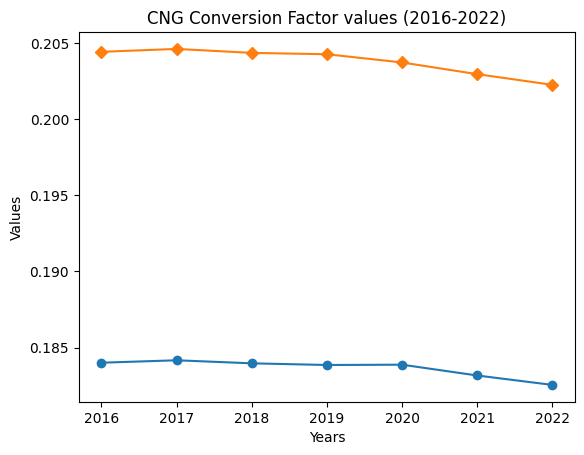

In [4]:
import matplotlib.pyplot as plt

# Create a line plot
plt.plot(gross_years, gross_values, marker = 'o')
plt.plot(net_years, net_values, marker = 'D')

# Add labels and title
plt.xlabel('Years')
plt.ylabel('Values')
plt.title('CNG Conversion Factor values (2016-2022)')
# plt.ylim(0)

# Display the plot
plt.show()